# Contextual Word Embeddings and Text Embeddings
* Last update: 11.11.2024
* Author: Johannes Maucher

Word Embeddings has been described in [section Representations](05representations). These Word Embeddings (), e.g. CBOW, Skipgram, Glove or the FastText subword embeddings are not contextual. This means that a word is mapped to a unique vector, independend of the context in which the word appears. This is a drawback because the meaning (semantic) of a word depends on the context (the surrounding words), in which the word appears. That's where **contextual Word Embeddings** come into play. In a  **contextual Word Embeddings** the vector representation of a single word or token, varies with the word's context. For example the word `play` will be mapped to another vector in the context of the sentence

* `the members of the house of parliament play a crucial role in this debate`

than in the context of the sentence

* `girls like to play with dolls`

Contextual word embeddings can be learned by transformers, as will be described in [section Transformers](../07neuralnetworks/attention). A common approach is to apply the pre-trained encoder-only transformer *BERT*. This approach will be demonstrated below.


## Load BERT Model and corresponding Tokenizer

In this section we will load a pre-trained *BERT* model and the corresponding tokenizer from [HuggingFace](https://huggingface.co/google-bert/bert-base-uncased). *BERT itself* will be described in [section Transformers](../07neuralnetworks/attention). 

**Import required Python modules:**

In [1]:
import random
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
random_seed = 1234
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

**Load pre-trained BERT Model and associated Tokenizer:**

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

## Define Input Input Sentence and Tokenize it

We start from an arbitrary sentence, which is assigned to the variable `text`:

In [5]:
text = "The lesson on artificial intelligence will be held on Monday"

Next, we tokenize the example sentence. For this we apply the `batch_encode_plus()`-method, which can also be applied for a bunch of texts, each represented as a variable of type `string`. The method automatically integrates the `CLS`- and the `SEP`-special token.  

In [6]:
encoding = tokenizer.batch_encode_plus( [text],# List of input texts
    padding=True,              # Pad to the maximum sequence length
    truncation=True,           # Truncate to the maximum sequence length if necessary
    return_tensors='pt',      # Return PyTorch tensors
    add_special_tokens=True    # Add special tokens CLS and SEP
)

The tokenizer-method returns a dictionary (`encoding` in the cell below), which keeps the keys `input_ids` and `attention_mask`.
The values of these keys are printed below:

In [7]:
input_ids = encoding['input_ids']  # Token IDs
# print input IDs
print(f"Input ID: {input_ids}")
attention_mask = encoding['attention_mask']  # Attention mask
# print attention mask
print(f"Attention mask: {attention_mask}")

Input ID: tensor([[  101,  1996, 10800,  2006,  7976,  4454,  2097,  2022,  2218,  2006,
          6928,   102]])
Attention mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


The attention mask defines the attention, which is drawn to each single token. Since in our example all elements of the `attention_mask` are the same, each token is considered equally in the calculation of the contextual embedding.

## Generate Word-Embeddings

In [8]:
# Generate embeddings using BERT model
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    word_embeddings = outputs.last_hidden_state  # This contains the embeddings

# Output the shape of word embeddings
print(f"Shape of Word Embeddings: {word_embeddings.shape}")

Shape of Word Embeddings: torch.Size([1, 12, 768])


As can be seen in the output above, `BERT` outputs for each of the 12 words in the input a contextual word embedding of length `768`.

Below we just demonstrate the tokenizer's `encode()` and `decode()`-method:

In [9]:
# Decode the token IDs back to text
decoded_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
#print decoded text
print(f"Decoded Text: {decoded_text}")
# Tokenize the text again for reference
tokenized_text = tokenizer.tokenize(decoded_text)
#print tokenized text
print(f"tokenized Text: {tokenized_text}")
# Encode the text
encoded_text = tokenizer.encode(text, return_tensors='pt')  # Returns a tensor
# Print encoded text
print(f"Encoded Text: {encoded_text}")

Decoded Text: the lesson on artificial intelligence will be held on monday
tokenized Text: ['the', 'lesson', 'on', 'artificial', 'intelligence', 'will', 'be', 'held', 'on', 'monday']
Encoded Text: tensor([[  101,  1996, 10800,  2006,  7976,  4454,  2097,  2022,  2218,  2006,
          6928,   102]])


Run the following code-cell only if you like to see the 12 embeddings, each of length 768. We don't execute this cell, because of the very long output:

In [9]:
#for token, embedding in zip(tokenized_text, word_embeddings[0]):
#    #print(f"Token: {token}")
#    print(f"Embedding: {embedding}")
#    print("\n")

Next, we calculate the text-embedding from the contextual word embeddings at the BERT-encoder's output. Note that are different methods to calculate a text embedding from the list of word embeddings. The most popular options are:

1. The encoder's output at the position of the `CLS`-token (first position in the input sequence) is a representation of the entire text and therefore can be applied as text-embedding.
2. Just calculate the mean of all contextual word embeddings at the output of the transformer-encoder.

Below we implement the second option:

In [10]:
sentence_embedding = word_embeddings.mean(dim=1)
print(f"Shape of Sentence Embedding: {sentence_embedding.shape}")
# Print the sentence embedding
print("Sentence Embedding:")
print(sentence_embedding)

Shape of Sentence Embedding: torch.Size([1, 768])
Sentence Embedding:
tensor([[-3.5001e-01, -3.3019e-01,  2.6465e-01,  7.5814e-02,  2.6252e-01,
         -4.2781e-01,  3.2828e-01,  6.8058e-01, -1.1294e-01, -1.3759e-01,
         -2.1079e-01, -2.7575e-01,  1.1764e-01,  1.5474e-01, -1.3306e-01,
         -6.5089e-03,  1.0366e-01, -2.5773e-02,  6.5012e-02,  4.5614e-02,
         -8.1534e-02, -9.1516e-02, -9.6652e-02,  6.5698e-01,  3.4971e-01,
          1.5745e-01, -2.1174e-02,  4.4196e-01, -1.7211e-01, -1.0172e-01,
         -2.7239e-02,  8.8936e-02, -7.1396e-02,  1.2314e-01,  1.8995e-01,
          1.0141e-01,  1.3849e-01, -2.6853e-01, -3.7551e-01,  5.1383e-01,
         -4.5088e-01, -8.5676e-02,  3.5888e-01, -8.5598e-02, -3.4887e-01,
         -3.2465e-01,  2.8293e-01, -2.6047e-01,  9.4687e-02, -3.1299e-01,
         -6.5420e-01,  3.6622e-01,  2.0525e-01,  1.6598e-01, -1.8717e-02,
          3.6724e-01,  4.8422e-02, -1.5004e-01, -2.3705e-01, -1.4570e-01,
          3.3358e-02,  1.8378e-01, -3.5432

## Calculate Similarity between texts
Up to now, we generated a text-embedding of our sample text `text`:

In [11]:
text

'The lesson on artificial intelligence will be held on Monday'

Now, we like to compare this text with other texts. For this, we first calculate the text-embeddings of the new texts. Then for each of these new texts the text-embedding is determined and the **cosine similarity** between our original `text` and all new texts is calculated. We expect, that we obtain the largest cosine similarity score for the text, whose semantics is closest to the sematics of the original `text`.

In [12]:
# Example sentence for similarity comparison
example_sentence0 = "Cuttlery and plates are piled up on the table"
example_sentence1 = "European cities suffer from severe air pollution"
example_sentence2 = "The machine learning module is in the master's program"
example_sentence3 = "Artificial intelligence is the future of technology"
example_sentence4 = "Waste of energy is a major concern for the environment"
example_sentences=[example_sentence0,example_sentence1,example_sentence2,example_sentence3,example_sentence4]
# Tokenize and encode the example sentence
example_encodings = tokenizer.batch_encode_plus(
    example_sentences,
    padding=True,
    truncation=True,
    return_tensors='pt',
    add_special_tokens=True
)

In [13]:
example_input_ids = example_encodings['input_ids']
#example_input_ids = example_encodings['input_ids'][1]
example_input_ids

tensor([[  101,  3013, 25091,  2100,  1998,  7766,  2024, 17835,  2039,  2006,
          1996,  2795,   102],
        [  101,  2647,  3655,  9015,  2013,  5729,  2250, 10796,   102,     0,
             0,     0,     0],
        [  101,  1996,  3698,  4083, 11336,  2003,  1999,  1996,  3040,  1005,
          1055,  2565,   102],
        [  101,  7976,  4454,  2003,  1996,  2925,  1997,  2974,   102,     0,
             0,     0,     0],
        [  101,  5949,  1997,  2943,  2003,  1037,  2350,  5142,  2005,  1996,
          4044,   102,     0]])

In [14]:
example_attention_mask = example_encodings['attention_mask']

In [16]:
# Generate embeddings for the example sentence
with torch.no_grad():
    example_outputs = model(example_input_ids, attention_mask=example_attention_mask)
    example_sentence_embedding = example_outputs.last_hidden_state.mean(dim=1)
    #example_sentence_embedding = example_outputs.last_hidden_state[0,0]

In [16]:

# Compute cosine similarity between the original sentence embedding and the example sentence embedding
similarity_score = cosine_similarity(sentence_embedding.reshape(1, -1), example_sentence_embedding)

# Print the similarity score
print(f"Similarities of {len(example_sentences)} example sentences and the original text \n\t",text)
for idx,sample in enumerate(example_sentences):
    print(f"\t\t{idx} : {sample} : Similarity Score = {similarity_score[0][idx]}")

Similarities of 5 example sentences and the original text 
	 The lesson on artificial intelligence will be held on Monday
		0 : Cuttlery and plates are piled up on the table : Similarity Score = 0.560899555683136
		1 : European cities suffer from severe air pollution : Similarity Score = 0.552908182144165
		2 : The machine learning module is in the master's program : Similarity Score = 0.724198043346405
		3 : Artificial intelligence is the future of technology : Similarity Score = 0.6622300744056702
		4 : Waste of energy is a major concern for the environment : Similarity Score = 0.5618582367897034


As can be seen in the output of the previous cell, we actually obtain the largest similarity-scores for the sentences, which are semantically closest to the original `text`.

## Calculate Similarity between different contextual embeddings of the same word
BERT outputs contextual word embeddings, i.e. a given word is not mapped to a unique vector. Instead the vector representations of a single word vary with the context of the word.

In the experiment below we generate 6 different sentences. In each of these sentences the word `show` is at the 2nd position. We like to investigate and compare the 6 different vectors generated at the BERT output for the word `show`.

In [17]:

s0 = "I show you the easiest way to solve this problem."
s1 = "They show remarkable resilience in difficult situations."
s2 = "We show our appreciation by sending a thank-you note."
s3 = "You show kindness to everyone you meet."
s4 = "Teachers show their students how to find reliable information."
s5 = "Friends show support when times get tough."
sents=[s0,s1,s2,s3,s4,s5]

Encode the 6 sentences:

In [18]:
# Tokenize and encode the example sentence
example_encodings = tokenizer.batch_encode_plus(
    sents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    add_special_tokens=True
)

By checking the output of the following cell, we can see, that in each of the 6 sentences the ID at position 3 (index = 2) is the same. This is because the second word in each sentence is the word `show`. Note that the second word is at the third position, because the special token `CLS` has been attached in the tokenisation method above. 

In [19]:
example_input_ids = example_encodings['input_ids']
#example_input_ids = example_encodings['input_ids'][1]
example_input_ids

tensor([[  101,  1045,  2265,  2017,  1996, 25551,  2126,  2000,  9611,  2023,
          3291,  1012,   102,     0],
        [  101,  2027,  2265,  9487, 24501, 18622, 10127,  1999,  3697,  8146,
          1012,   102,     0,     0],
        [  101,  2057,  2265,  2256, 12284,  2011,  6016,  1037,  4067,  1011,
          2017,  3602,  1012,   102],
        [  101,  2017,  2265, 16056,  2000,  3071,  2017,  3113,  1012,   102,
             0,     0,     0,     0],
        [  101,  5089,  2265,  2037,  2493,  2129,  2000,  2424, 10539,  2592,
          1012,   102,     0,     0],
        [  101,  2814,  2265,  2490,  2043,  2335,  2131,  7823,  1012,   102,
             0,     0,     0,     0]])

In [20]:
example_attention_mask = example_encodings['attention_mask']

Next, we generate for each of the 6 sentences the corresponding BERT output. As before, for each sentence the i.th output vector of is the contextual embedding of the i.th input word. Again, we have to take into account, that the special token `CLS` has been added at the first position of each sentence.

In contrast to the previous experiments, we now do not calculate the mean over all contextual word embeddings of a sentence. Instead we just pick out the contextual word embedding at postion with index 2. Because at this position we have in each of the 6 sentences the same word `show`. 

In [21]:
# Generate embeddings for the second word (IDX=2) of the example sentence
IDX=2
with torch.no_grad():
    example_outputs = model(example_input_ids, attention_mask=example_attention_mask)
    #example_sentence_embedding = example_outputs.last_hidden_state.mean(dim=1)
    example_sentence_embedding = example_outputs.last_hidden_state[:,2]

The output `example_sentence_embedding` is a tensor of shape (6, 768), where 6 is the number of example sentences and 768 is the dimension of the embeddings.

In [22]:
example_sentence_embedding.shape

torch.Size([6, 768])

Next, we calculate the pairwise cosine similarity between all 6 sentences:

In [23]:
similarity_score = cosine_similarity(example_sentence_embedding)

We obtain a $6 \times 6$ array, whose value at row $i$, column $j$ is the cosine-similarity between sentence $i$ and sentence $j$.

In [24]:
similarity_score.shape

(6, 6)

In [25]:
import numpy as np
np.set_printoptions(precision=3)
similarity_score

array([[1.   , 0.39 , 0.487, 0.508, 0.685, 0.472],
       [0.39 , 1.   , 0.495, 0.655, 0.483, 0.6  ],
       [0.487, 0.495, 1.   , 0.538, 0.543, 0.533],
       [0.508, 0.655, 0.538, 1.   , 0.536, 0.709],
       [0.685, 0.483, 0.543, 0.536, 1.   , 0.59 ],
       [0.472, 0.6  , 0.533, 0.709, 0.59 , 1.   ]], dtype=float32)

Finally we visualise the pairwise similarities in a heatmap:

In [27]:
import seaborn as sns

<Axes: >

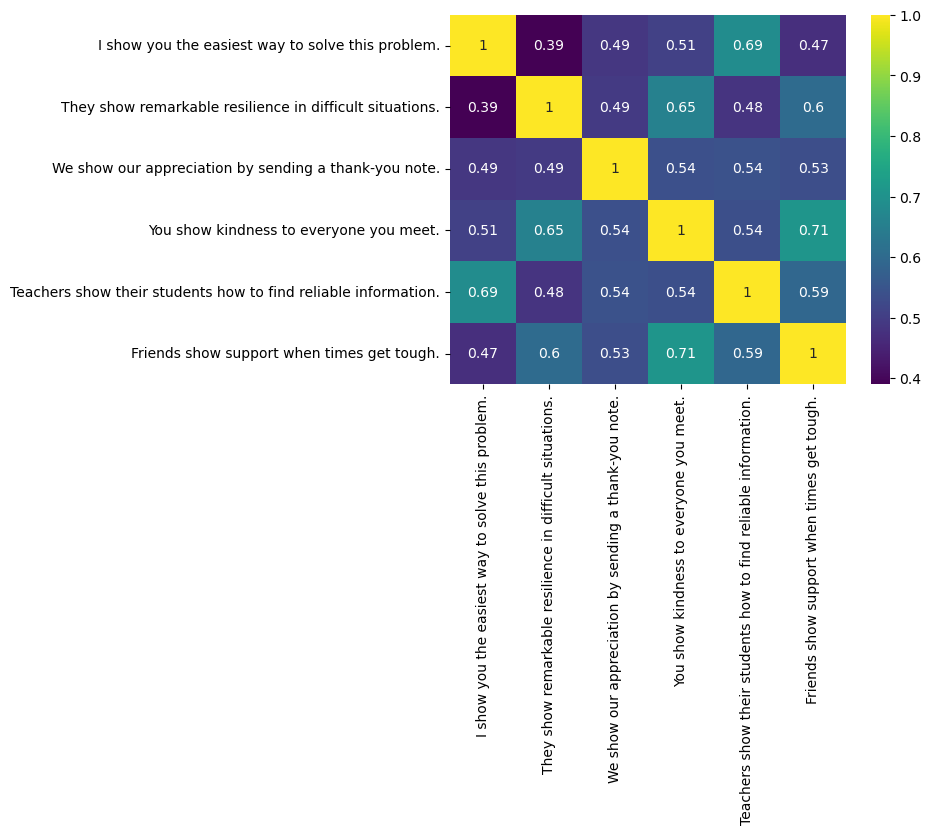

In [28]:
sns.heatmap(similarity_score, annot=True, cmap='viridis', xticklabels=sents, yticklabels=sents)

The heatmap shows, that the cosine-similarity between the embeddings of our word `show` in sentence $i$ and the same word in the context of the same sentence $j=i$ is 1. However, for $j \neq i$ the cosine similarities are $<1$, which proves that our word `show` has distinct embeddings in the distinct contexts. The embeddings in sentence 0 and sentence 1 show the smallest similarity score. This is plausible, because in sentence 1 the word `show` has a significantly different meaning than in sentence 0. The highest value for different sentences is obtained for sentence 3 and sentence 5. This is also plausible, because in these two sentences the meaning of the word `show` is similar.